# DATA RETRIEVAL: 💻

-  Data is acquired without any manual downloads, utilized Kaggle's API Token System to download data directly from here!
    - (Data Creds to: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia )

In [3]:
# install kaggle library to access its API.
!pip install  -q kaggle


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# create dir.
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
!touch ~/.kaggle/kaggle.json

In [23]:
kaggle_api_token = {"username":"akkik04","key":"08a4a72155bfe94596423a5541b07baa"}

In [24]:
import json

with open('/root/.kaggle/kaggle.json','w') as f:
    json.dump(kaggle_api_token, f)

In [25]:
# setting permissions to be able to read and write here.
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
# remotely downloading the dataset.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

100%|██████████████████████████████████████▉| 2.29G/2.29G [00:21<00:00, 105MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:27<00:00, 91.0MB/s]


In [27]:
# extracting data.
import zipfile
with zipfile.ZipFile('./chest-xray-pneumonia.zip','r')  as z:
    z.extractall('./data')

# VISUALIZING THE INITIAL TRAINING DATASET: 📊

-  Exploring the dataset from the Kaggle Chest X-Ray Pneumonia dataset, which contains a large number of chest X-ray images labeled with "normal" or "pneumonia" classes.
- Through visualizing the data, we can gain insights into the dataset and prepare it for machine learning models that can help diagnose and treat pneumonia (which is our main purpose).

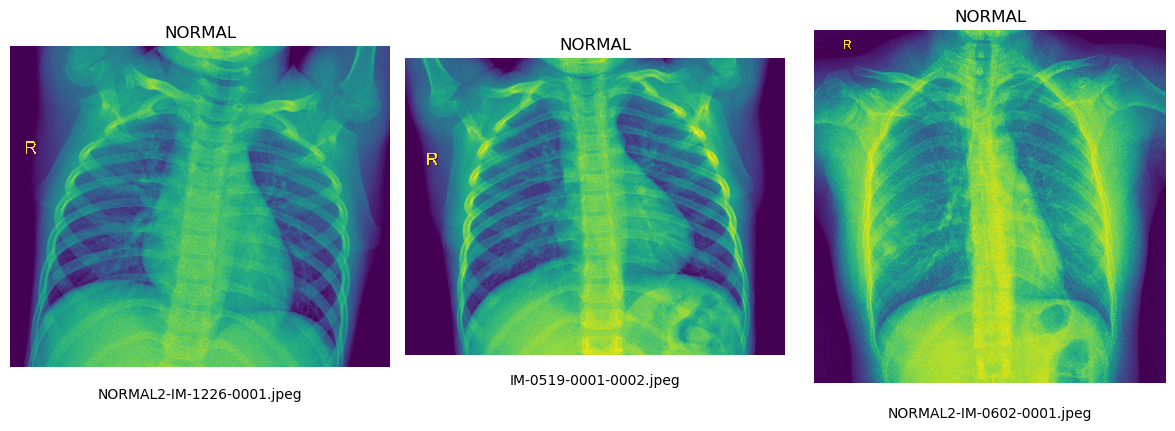

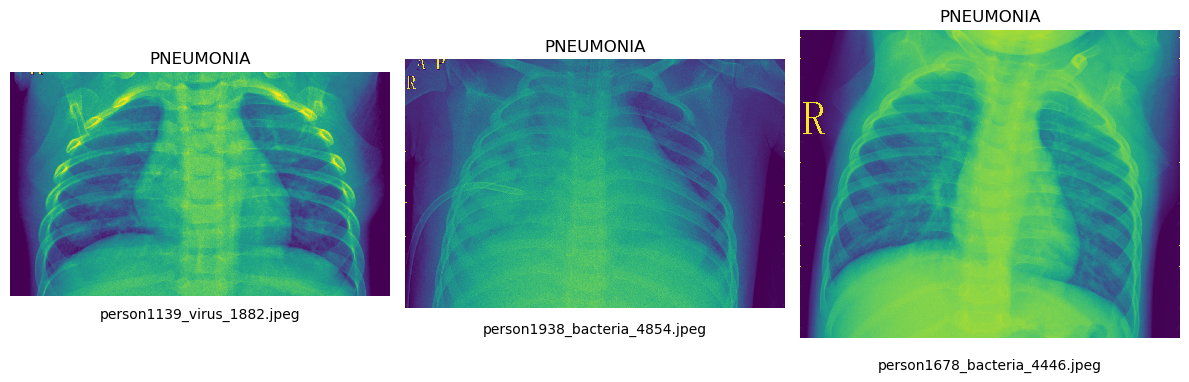

In [23]:
# import required libraries.
import os
import glob
import random
import matplotlib.pyplot as plt

# defining our function to retrieve a random image:
def retrieve_an_image(directory, image_status):
    
    # get the path to the images directory, and retrieve all the image files with the specified status
    images_path = os.path.join(directory, image_status)
    image_files = glob.glob(os.path.join(images_path, '*.jpeg'))
    
    # randomly select 3 image files
    image_files = random.sample(image_files, 3)
    
    # create a 1x3 grid of subplots, and loop over the subplots and display each image with its label and file name.
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes.flatten()):
        
        # load the image file
        img = plt.imread(image_files[i])
        
        # display the image in the subplot
        ax.imshow(img)
        
        # set the label of the subplot to the image status
        ax.set_title(image_status)
        
        # set the file's basename as text.
        ax.text(0.5, -0.1, os.path.basename(image_files[i]), ha='center', transform=ax.transAxes)
        
        # turn off the axis lines and labels
        ax.axis('off')
        
    # adjust the spacing between subplots
    plt.tight_layout()
    
    # display the subplots
    plt.show()
    
# function call to view data.
retrieve_an_image('./data/chest_xray/chest_xray/train', 'NORMAL')
retrieve_an_image('./data/chest_xray/chest_xray/train', 'PNEUMONIA')

# DATA-SET MODIFICATIONS/CLEAN-UP: 🧹

- **Modification #1**:  
    - The SageMaker Image Classifier expects the data (once uploaded to our AWS-S3 bucket) to be under just one 'train' folder.
    - Going to have to make some modifications to the way the initial data directories are set-up!
    - Ideally I'd want the images in both the 'NORMAL' and 'PNEUMONIA' folders to be clumped into one big train folder, re-labelling as follows: 'train_pneumonia(img_num).jpeg' & 'train_normal(img_num).jpeg'  

* **Modification #2**: 
    - The 'image_shape', when using a pre-trained model has to be 224 x 224 image size, meaning we're going to have to re-size the images in the dataset.

- **Modification #3**:
    - The images seen above, when visualizing the dataset, are not 'gray-scale', this is due to an internal aspect of matplotlib.
    - Hence, going to turn all images in the dataset to 'gray-scale' for the pre-trained model (Resnet) being used, when analyzation is occuring.

Refer to the [AWS-SageMaker Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html) regarding image-classification for more information.😃

In [4]:
# MODIFICATIONS TO THE TRAINING-DATASET.

import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# defining the folder paths of the images to be modified.
folders_to_modify = ['./data/chest_xray/train/*/*.jpeg', './data/chest_xray/test/*/*.jpeg', './data/chest_xray/val/*/*.jpeg']

for folder_to_modify in folders_to_modify:
    
    img_paths = glob.glob(folder_to_modify)

    # counters for img-names.
    p_counter = 0
    n_counter = 0

    for i in img_paths:

        # If the file path contains "person", it means the image has pneumonia.
        if "person" in i:

            # open the image file, re-size it, and save it to a new directory with a modified name.
            ith_img = Image.open(i)
            img = ith_img.resize((224, 224))
            plt.imsave(fname='./data/chest_xray/train' + '/' + '/train_pneumonia' + str(p_counter) + '.jpeg', arr=img, format='jpeg', cmap='gray')
            p_counter += 1

        # If the file path contains "IM" or "NORMAL", it means the image is normal.
        elif "IM" in i or "NORMAL" in i:

            # open the image file, re-size it, and save it to a new directory with a modified name.
            ith_img = Image.open(i)
            img = ith_img.resize((224, 224))
            plt.imsave(fname='./data/chest_xray/train' + '/' + '/train_normal' + str(n_counter) + '.jpeg', arr=img, format='jpeg', cmap='gray')
            n_counter += 1


# UNDERSTANDING THE DATA RATIO AFTER CLEAN-UP ⚒️

- This code retrieves information about the lung x-ray images and visualizes the count of normal and pneumonia cases for each dataset type (train, test, validation). 
- Implemented pandas and seaborn libraries to plot a categorical chart, with image count info for each type of dataset.

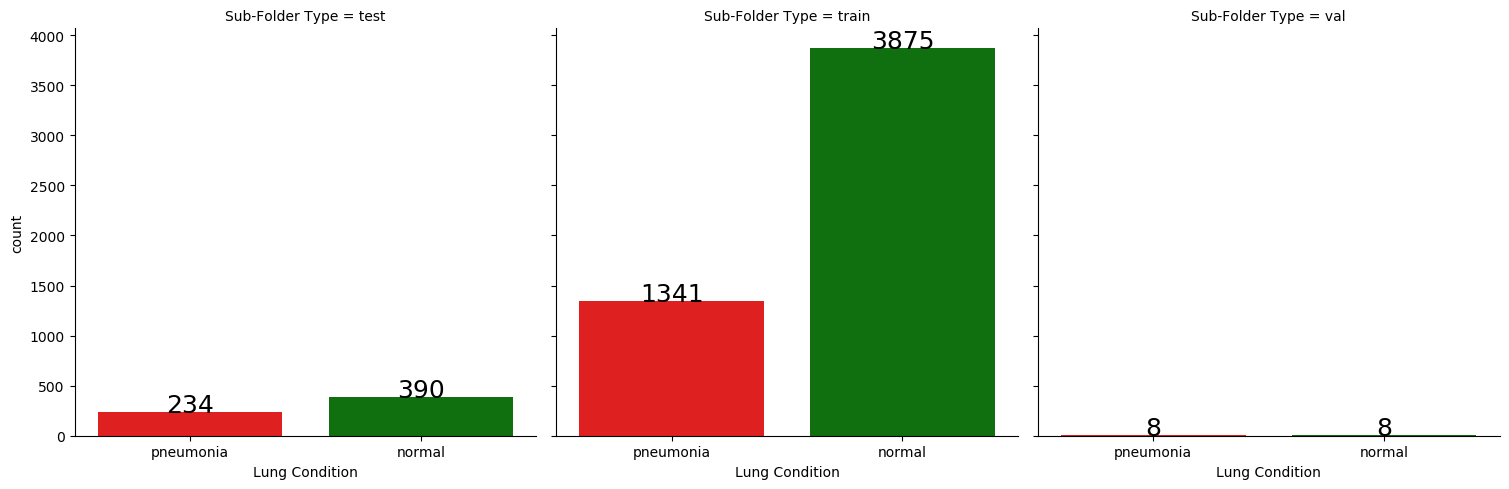

In [2]:
# RETRIEVING IMAGE INFO FOR VISUALIZATION PURPOSES.

import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import pandas as pd
import seaborn as sns

# creating lists to append folder, condition, and img-filename info.
sub_folders = []
lungs_condition = []
img_filenames = []

# searching all images within the main-folder.
main_folder_to_search = './data/chest_xray/*/*.jpeg'
files_in_main_folder = glob.glob(main_folder_to_search)

for filename in files_in_main_folder:
    
    # checking train-dataset.
    if 'train' in filename:
        
        # categorizing the normal vs. pneumonic images.
        if 'normal' in filename:
            sub_folders.append("train")
            lungs_condition.append('pneumonia')
            img_filenames.append(filename)
        elif 'pneumonia' in filename:
            sub_folders.append("train")
            lungs_condition.append('normal')
            img_filenames.append(filename)
            
    # checking test-dataset.
    elif 'test' in filename:
        
        # categorizing the normal vs. pneumonic images.
        if 'normal' in filename:
            sub_folders.append("test")
            lungs_condition.append('pneumonia')
            img_filenames.append(filename)
        elif 'pneumonia' in filename:
            sub_folders.append("test")
            lungs_condition.append('normal')
            img_filenames.append(filename)
    
    # checking validation dataset
    elif 'val' in filename:
        
        # categorizing the normal vs. pneumonic images.
        if 'normal' in filename:
            sub_folders.append("val")
            lungs_condition.append('pneumonia')
            img_filenames.append(filename)
        elif 'pneumonia' in filename:
            sub_folders.append("val")
            lungs_condition.append('normal')
            img_filenames.append(filename)

lung_data_df = pd.DataFrame({"Sub-Folder Type":sub_folders, "Lung Condition":lungs_condition, "Image FileName":img_filenames})
graph = sns.catplot(x="Lung Condition", col="Sub-Folder Type", kind="count", palette=sns.color_palette(['red', 'green']), data=lung_data_df, legend=True)

# add labels to the bars
for ax in graph.axes.flat:
    for p in ax.patches:
        ax.text(x=p.get_x()+p.get_width()/2,
                y=p.get_height() + 1,
                s=int(p.get_height()),
                ha='center',
                fontsize = '18')

# CREATING THE .LST FILES FOR AWS S3 🗒️

• .lst files are important for AWS S3 and image classification tasks with AWS because they are used to store metadata about image files.

• By using .lst files to manage image data, users can simplify the process of creating and managing large datasets, which can be particularly useful when working with large numbers of images.

• Specifically, .lst files contain information about the location of image files, as well as labels that indicate the class to which each image belongs.

                **We'll create these .lst files, save them to our CWD, and pipe them into our AWS S3 bucket!**

In [3]:
import os
import glob
import pandas as pd

# creating .lst files for these directories.
data_folders = ['./data/chest_xray/train/*.jpeg', './data/chest_xray/test/*.jpeg']

# creating two empty dataframes with columns 'labels' and 's3_path' to store the image labels and file paths for the train and test datasets.
train_df_lst = pd.DataFrame(columns=['labels', 's3_path'], dtype=object)
test_df_lst = pd.DataFrame(columns=['labels', 's3_path'], dtype=object)

# iterating over the two data folders (train and test) and using glob.glob() to get a list of all the image files in the folder.
for data_folder in data_folders:
    test_imgs_path = glob.glob(data_folder)
    counter = 0
    ith_label = ''
    
    # declaring the 'pneumonic' x-ray scans with a label of 1.
    # declaring the 'normal' x-ray scans with a label of 0.
    
    if 'train' in data_folder:
        for i in test_imgs_path:
            if 'pneumonia' in i:
                ith_label = 1
            else:
                ith_label = 0
            train_df_lst.loc[counter] = [ith_label, os.path.basename(i)]
            counter += 1
    
    elif 'test' in data_folder:
         for i in test_imgs_path:
            if 'pneumonia' in i:
                ith_label = 1
            else:
                ith_label = 0
            test_df_lst.loc[counter] = [ith_label, os.path.basename(i)]
            counter += 1

# sanity test LOL.
print("Sanity Test #1:\n\n", train_df_lst.head())
print("\n\nSanity Test #2:\n\n", test_df_lst.head())

Sanity Test #1:

   labels                   s3_path
0      0     train_normal1203.jpeg
1      1  train_pneumonia3349.jpeg
2      1   train_pneumonia478.jpeg
3      1  train_pneumonia1567.jpeg
4      1  train_pneumonia2296.jpeg


Sanity Test #2:

   labels                 s3_path
0      0       test_normal4.jpeg
1      1    test_pneumonia1.jpeg
2      1  test_pneumonia359.jpeg
3      1  test_pneumonia197.jpeg
4      0     test_normal103.jpeg


In [4]:
# declaring a function to save the .lst files:
def save_the_lst_files(df, prefix):
    return df[["labels","s3_path"]].to_csv(f"{prefix}.lst", sep='\t', index=True, header=False)

# call the function to save the .lst files:
save_the_lst_files(train_df_lst.copy(), "train")
save_the_lst_files(test_df_lst.copy(), "test")

# UPLOADING DATA TO AWS S3 BUCKET 🪣

The code below performs the task of uploading image data and metadata files to an Amazon Web Services (AWS) S3 bucket.

1. First, it imports the necessary libraries, 'os' and 'boto3', which enable the code to interact with the local file system and the AWS S3 service, respectively.

2. The code then specifies the details of the S3 bucket to be used for the upload, including the name of the bucket, the region in which it is located, and the role ARN (Amazon Resource Name).

3. Next, the code uses the 'aws s3 sync' command to synchronize the contents of the 'train' and 'test' folders on the local system with the S3 bucket specified in the previous step. This ensures that all the image data is available on the cloud.

4. Finally, the code uploads two metadata files, 'train.lst' and 'test.lst', to the S3 bucket. These files contain information about the images, such as their location and labels, and are necessary for training machine learning models using the data.

A picture of my AWS bucket's main directories is attached below for reference:

![](https://i.imgur.com/rk8zIJX.jpg)


In [7]:
# uploading the images from the 'train' and 'test' folders to the S3 bucket.

# importing the 'os' and 'boto3' libraries to interact with the local file system and AWS S3 service respectively.
import os
import boto3

# AWS S3 bucket details.                                                 
bucket = 'pulmo-lens'
region = 'ca-central-1'

# synchronize the contents of the local'train' & 'test' folders to the S3 bucket with the specified details.
os.environ["DEFAULT_S3_BUCKET"]=bucket
!aws s3 sync ./data/chest_xray/train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./data/chest_xray/test s3://${DEFAULT_S3_BUCKET}/test/

# upload two files, train.lst and test.lst, to the S3 bucket
boto3.Session().resource('s3').Bucket(bucket).Object("train.lst").upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(bucket).Object("test.lst").upload_file('./test.lst')

# BEGINNING THE MODEL TRAINING 🤖

**Overview of the main parts in the Code**:

## Packages Used
- `time`
- `os`
- `glob`
- `sagemaker`
- `boto3`

## Counting Training Images
The code counts how many images are in the training dataset directory.

## AWS S3 Bucket Details
This section specifies the AWS S3 bucket name and region.

## Retrieving the Docker Image URI
This section retrieves the Docker image URI for the `image-classification` framework in the respective region.

## Specifying the Output Storage Location
This section specifies the output storage location for the trained model and the artifacts.

## Retrieving the IAM Role
This section retrieves the Amazon Resource Name (ARN) of the IAM role used to execute the current notebook or script in SageMaker.

## Creating the Estimator Object
This section creates an estimator object that can be used to train the machine learning model. It uses the following hyperparameters:
- `image_shape`: sets the shape of the input images to the model, RGB with dimensions of 224x224 pixels.
- `num_classes`: the number of classes the model is trained to predict.
- `use_pretrained_model`: using a pretrained model.
- `num_training_samples`: the training images are the samples for training.
- `epochs`: sets the number of epochs (iterations) that the model will be trained for.
- `augmentation_type`: enabling data-augmentation techniques.
- `early_stopping`: a technique used to prevent overfitting of the model to the training data by stopping training when the performance on a validation set stops improving.
- `early_stopping_min_epochs`: the minimum number of epochs that the model should be trained for before early stopping can be applied.
- `early_stopping_patience`: the number of epochs to wait for the validation performance to improve before stopping the training early.
- `lr_scheduler_factor`: 
- `lr_scheduler_step`: sets the epochs at which the learning rate should be reduced.

## Specifying Hyperparameters
This section specifies the dynamic hyperparameters that are going to be tuned, including the learning rate, mini-batch size, and optimizer.

## Creating the Hyperparameter Tuner Object
This section sets up the "actual" hyperparameter tuner object with the properties decided above.

## Specifying the Input Data
This section specifies the input data for the training job.

## Job Naming
Since we're running five training jobs, this section generates a separate name for each one, and keep in mind I specified no parallel jobs.

## Final Steps
The last step is to launch the training jobs, which will tune the hyperparameters and output the trained model artifacts to the specified location in our S3 bucket.


In [ ]:
import time
import os
import glob
import sagemaker
import boto3
from sagemaker import image_uris, get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.session import TrainingInput

# counting how many training images we have:
train_img_count = 0
for filepath in glob.glob('./data/chest_xray/train/*.jpeg'):
    train_img_count += 1

# AWS S3 bucket details.                                                 
bucket = 'pulmo-lens'
region = 'ca-central-1'

session = sagemaker.Session()

# retrieving the Docker image URI for the image-classification framework in the respective region.
algo_image = image_uris.retrieve(
    region=boto3.Session().region_name,
    framework="image-classification"
)

# specifying the output of storage for the trained model and the artifacts.
s3_output_location = f"s3://{bucket}/models/"

# retrieve the Amazon Resource Name (ARN) of the IAM role used to execute the current notebook or script in SageMaker.
exec_role = get_execution_role()

# creating an estimator object that can be used to train the machine learning model.
ml_model = sagemaker.estimator.Estimator(
    
    algo_image, # container image
    role = exec_role, # AWS IAM role for perms verification.
    instance_count = 1, # number of AWS EC2 instances used for training (training is more efficient in our case, when we train on one instance).
    instance_type = "ml.p3.2xlarge", # using AWS GPU instance to speed up training.
    volume = 50, # size of the EBS volume in GB to use for storing data during training.
    max_run = 432000, # maximum amount of time in seconds that the training job can run for.
    input_mode = "File", # specifies how data should be passed to the training algorithm. In this case, it is set to "File".
    output_path = s3_output_location, # S3 location to which the trained model artifacts will be saved.
    sagemaker_session = session, # session object.
)

train_img_count = 5216
# setting hyper-parameters for the model.
ml_model.set_hyperparameters(
    
    image_shape = "3,224,224", #  sets the shape of the input images to the model, RGB with dimensions of 224x224 pixels.
    num_classes = 2, # number of classes the model is trained to predict.
    use_pretrained_model = 1, # using a pretrained model.
    num_training_samples = train_img_count, # the training images are the samples for training.
    epochs = 20, #  sets the number of epochs (iterations) that the model will be trained for.
    augmentation_type = 'crop_color_transform', # enabling data-augmentation techniques.
    early_stopping = True, # early stopping is a technique used to prevent overfitting of the model to the training data by stopping training when the performance on a validation set stops improving.
    early_stopping_min_epochs = 14, # minimum number of epochs that the model should be trained for before early stopping can be applied.
    early_stopping_patience = 5, # the number of epochs to wait for the validation performance to improve before stopping the training early.
    lr_scheduler_factor = 0.1, # 
    lr_scheduler_step = "14,16,18", # sets the epochs at which the learning rate should be reduced. 
)

# specifying the dynamic hyper-parameters that I want to tune.
hyperparameter_ranges = {
    "learning_rate" : ContinuousParameter(0.01, 0.1), # a continuous range between 0.01 and 0.1 is specified for the model to choose from.
    "mini_batch_size" : CategoricalParameter([8, 16, 32]), # a categorical range of 8, 16, and 32 is specified for the model to choose from.
    "optimizer" : CategoricalParameter(["sgd", "adam"]), # chosen optimization algo's.
}

# setting up the "actual" hyperparameter tuner object with the properties decided above.
tuner = HyperparameterTuner(
    estimator = ml_model, # tying our created estimator
    objective_metric_name = "validation:accuracy", # tell the model to evaluate the performance based on "validation:accuracy".
    objective_type = "Maximize", # tell the model I want to maximize the validation accuracy.
    hyperparameter_ranges = hyperparameter_ranges, # tying our defined hyperparameter ranges.
    max_jobs = 5, # running 5 training jobs
    max_parallel_jobs = 1, # allow only 1 parallel job at a time.
)

# since we're running 5 training jobs, we need seperate names for each one.
ith_job_prefix = "classifier"
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
ith_job_name = ith_job_prefix + timestamp

# specifying the input data for the training job. 
ml_model_inputs = {
    "train":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/train/", content_type='application/x-image'),
    "validation":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/test/", content_type='application/x-image'),
    "train_lst":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/train.lst", content_type='application/x-image'),
    "validation_lst":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/test.lst", content_type='application/x-image'),
}

# starting the training job FINALLY LOL (not working currently AWS ACCESS ISSUES)
tuner.fit(inputs = ml_model_inputs, job_name = ith_job_name, logs = True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# TESTING WITH A LOCAL INFERENCE 🤔

In [2]:
import sagemaker
from sagemaker import get_execution_role, image_uris
import boto3

# retrieving the Docker image URI for the image-classification framework in the respective region.
algo_image = image_uris.retrieve(
    region=boto3.Session().region_name,
    framework="image-classification"
)

# defining the sagemaker model for deployment.
model = sagemaker.model.Model(
    image_uri = algo_image,
    model_data = 's3://pulmo-lens/models/classifier-2023-03-16-21-41-13-003-4680874e/output/model.tar.gz',
    role = get_execution_role()
)

# deploying the model.
deployment = model.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    endpoint_name = 'Test-PulmoLens-Classifier'
)

---------!

In [9]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
import base64

# using the endpoint created to make a local inference for testing.
predictor = Predictor("Test-PulmoLens-Classifier")

# testing the file name of the validation image to be predicted. In this case, the image is located at "data/chest_xray/val/val_pneumonia0.jpeg".
# this image shows pneumonia btw.
file_name = "data/chest_xray/val/val_pneumonia0.jpeg"
predictor.serializer = IdentitySerializer("image/jpeg")

# opens the image file in binary mode and reads the contents of the file.
with open(file_name, "rb") as f:
    data = f.read()

# the predict method sends the input data to the endpoint and returns the output.
inference = predictor.predict(data=data)
print(inference)

b'[0.0013139197835698724, 0.9986861348152161]'
